In [21]:
# Cell 1 – Install dependencies (run once per runtime)

!pip install -q open_clip_torch faiss-cpu tqdm pandas pillow matplotlib


##2 – Imports & basic config

In [22]:
# Cell 2 – Imports & config

import os
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms as T

import faiss
import open_clip

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Paths (you can tweak these as you like)
BASE_DIR = Path("/content")
COCO_DIR = BASE_DIR / "coco"
COCO_IMAGES_DIR = COCO_DIR / "val2017"          # we'll use val2017
COCO_ANN_DIR = COCO_DIR / "annotations"
COCO_CAPTIONS_FILE = COCO_ANN_DIR / "captions_val2017.json"

# TestSet-2 (phone images)
PHONE_IMAGES_DIR = BASE_DIR / "phone_images"    # you will create this folder
PHONE_CAPTIONS_CSV = BASE_DIR / "phone_captions.csv"  # you will create this file

# Retrieval config
N_COCO_INDEX_IMAGES = 4000   # number of COCO images to index (you can increase if GPU/Colab allows)
N_TEST1_QUERIES = 500        # size of TestSet-1
TOPK_EVAL = (1, 5, 10)       # Recall@K metrics

# Embedding dtype (for FAISS)
EMBED_DTYPE = np.float32


Using device: cuda


##3 – Download & extract MS-COCO (val2017)

In [23]:
# Cell 3 – Download COCO val2017 (images + captions)

COCO_DIR.mkdir(parents=True, exist_ok=True)

# Images (val2017)
if not COCO_IMAGES_DIR.exists():
    !wget -q http://images.cocodataset.org/zips/val2017.zip -O {COCO_DIR / "val2017.zip"}
    !unzip -q {COCO_DIR / "val2017.zip"} -d {COCO_DIR}

# Annotations
if not COCO_CAPTIONS_FILE.exists():
    !wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O {COCO_DIR / "annotations_trainval2017.zip"}
    !unzip -q {COCO_DIR / "annotations_trainval2017.zip"} -d {COCO_DIR}

print("Images dir:", COCO_IMAGES_DIR)
print("Captions file:", COCO_CAPTIONS_FILE)


Images dir: /content/coco/val2017
Captions file: /content/coco/annotations/captions_val2017.json


##4 – Build a COCO caption dataframe

In [24]:
# Cell 4 – Prepare COCO captions dataframe

with open(COCO_CAPTIONS_FILE, "r") as f:
    coco_data = json.load(f)

# image_id -> file_name
id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

rows = []
for ann in coco_data["annotations"]:
    img_id = ann["image_id"]
    caption = ann["caption"]
    fname = id_to_filename[img_id]
    img_path = COCO_IMAGES_DIR / fname
    rows.append({
        "image_id": img_id,
        "file_name": fname,
        "image_path": str(img_path),
        "caption": caption
    })

coco_df = pd.DataFrame(rows)
print("Total caption rows:", len(coco_df))
coco_df.head()


Total caption rows: 25014


,image_id,file_name,image_path,caption
0,179765,000000179765.jpg,/content/coco/val2017/000000179765.jpg,A black Honda motorcycle parked in front of a ...
1,179765,000000179765.jpg,/content/coco/val2017/000000179765.jpg,A Honda motorcycle parked in a grass driveway
2,190236,000000190236.jpg,/content/coco/val2017/000000190236.jpg,An office cubicle with four different types of...
3,331352,000000331352.jpg,/content/coco/val2017/000000331352.jpg,A small closed toilet in a cramped space.
4,517069,000000517069.jpg,/content/coco/val2017/000000517069.jpg,Two women waiting at a bench next to a street.


##5 – Build index set & TestSet-1 from COCO

In [25]:
# Cell 5 – Create index set & TestSet-1 from COCO

# Unique images
unique_image_ids = coco_df["image_id"].unique()
print("Unique images in val2017:", len(unique_image_ids))

# How many images to index
n_index = min(N_COCO_INDEX_IMAGES, len(unique_image_ids))
selected_image_ids = np.random.choice(unique_image_ids, size=n_index, replace=False)

# Subset of COCO rows for those images
index_df = coco_df[coco_df["image_id"].isin(selected_image_ids)].copy()

# One caption per image for the gallery representation
gallery_df = index_df.drop_duplicates("image_id").reset_index(drop=True)

# Map image_id -> gallery index
imgid_to_gallery_idx = {row.image_id: i for i, row in gallery_df.iterrows()}

# Build TestSet-1 (queries): Random captions where image is in gallery
test1_df = index_df.copy()
test1_df["gallery_idx"] = test1_df["image_id"].map(imgid_to_gallery_idx)
test1_df = test1_df.dropna(subset=["gallery_idx"]).reset_index(drop=True)

# Sample a smaller query set for faster evaluation
if len(test1_df) > N_TEST1_QUERIES:
    test1_df = test1_df.sample(N_TEST1_QUERIES, random_state=42).reset_index(drop=True)

print("Gallery size (COCO):", len(gallery_df))
print("TestSet-1 query captions:", len(test1_df))
test1_df.head()


Unique images in val2017: 5000
Gallery size (COCO): 4000
TestSet-1 query captions: 500


,image_id,file_name,image_path,caption,gallery_idx
0,113867,000000113867.jpg,/content/coco/val2017/000000113867.jpg,A picture of an open air zone that looks incre...,3711
1,393093,000000393093.jpg,/content/coco/val2017/000000393093.jpg,a green orange and silver train and some cars,1203
2,61171,000000061171.jpg,/content/coco/val2017/000000061171.jpg,Several cows and a horse are eating hay.,1943
3,119088,000000119088.jpg,/content/coco/val2017/000000119088.jpg,The shirtless man plays frisbee in the water.,1969
4,418696,000000418696.jpg,/content/coco/val2017/000000418696.jpg,a traffic light hanging from a wire above a st...,665


In [26]:
# Cell 6 – Load / define TestSet-2 (phone images + captions)

PHONE_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
print("Place your phone images in:", PHONE_IMAGES_DIR)

if PHONE_CAPTIONS_CSV.exists():
    phone_df = pd.read_csv(PHONE_CAPTIONS_CSV)
    assert "filename" in phone_df.columns and "caption" in phone_df.columns, \
        "phone_captions.csv must have columns: filename, caption"

    phone_df["image_path"] = phone_df["filename"].apply(
        lambda fn: str(PHONE_IMAGES_DIR / fn)
    )

    # keep only those that actually exist
    phone_df = phone_df[phone_df["image_path"].apply(os.path.exists)].reset_index(drop=True)
    print("Loaded phone captions:", len(phone_df))
    display(phone_df.head())
else:
    phone_df = pd.DataFrame(columns=["filename", "caption", "image_path"])
    print("⚠️ phone_captions.csv not found. Create it at:", PHONE_CAPTIONS_CSV)
    print("For now, TestSet-2 will be empty.")


Place your phone images in: /content/phone_images
Loaded phone captions: 16


,filename,caption,image_path
0,IMG_20240408_230922.jpg,A person lying down with a small white kitten ...,/content/phone_images/IMG_20240408_230922.jpg
1,IMG_20240408_231414.jpg,"A white kitten sitting on a laptop keyboard, l...",/content/phone_images/IMG_20240408_231414.jpg
2,IMG_20240408_231456.jpg,A white kitten resting on a laptop keyboard be...,/content/phone_images/IMG_20240408_231456.jpg
3,IMG_20240413_233645.jpg,A white kitten sleeping on a person's lap in f...,/content/phone_images/IMG_20240413_233645.jpg
4,IMG20250613171548.jpg,A child smiling while sitting next to a person...,/content/phone_images/IMG20250613171548.jpg


In [27]:
# Cell 7 – Load OpenCLIP model and preprocessing

MODEL_NAME = "ViT-B-32"
PRETRAINED = "laion2b_s34b_b79k"

model, _, preprocess = open_clip.create_model_and_transforms(
    MODEL_NAME, pretrained=PRETRAINED
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)

model.to(DEVICE)
model.eval()

print("Loaded:", MODEL_NAME, PRETRAINED)


Loaded: ViT-B-32 laion2b_s34b_b79k


In [28]:
# Cell 8 – Encoding helpers

def encode_images(paths):
    """
    Encode a list of image paths into normalized embeddings (numpy array).
    """
    embs = []
    with torch.no_grad():
        for p in tqdm(paths, desc="Encoding images"):
            img = Image.open(p).convert("RGB")
            img = preprocess(img).unsqueeze(0).to(DEVICE)
            feat = model.encode_image(img)
            feat = F.normalize(feat, dim=-1)
            embs.append(feat.cpu())
    embs = torch.cat(embs, dim=0)
    return embs.cpu().numpy().astype(EMBED_DTYPE)


def encode_texts(texts):
    """
    Encode a list of strings into normalized embeddings (numpy array).
    """
    with torch.no_grad():
        tokens = tokenizer(texts).to(DEVICE)
        feats = model.encode_text(tokens)
        feats = F.normalize(feats, dim=-1)
    return feats.cpu().numpy().astype(EMBED_DTYPE)


In [29]:
# Cell 9 – Build FAISS index for COCO gallery (TestSet-1)

gallery_paths = gallery_df["image_path"].tolist()
print("Number of gallery images:", len(gallery_paths))

coco_gallery_embs = encode_images(gallery_paths)
d = coco_gallery_embs.shape[1]

index_coco = faiss.IndexFlatIP(d)  # cosine similarity (vectors are normalized)
index_coco.add(coco_gallery_embs)

print("COCO index size:", index_coco.ntotal)


Number of gallery images: 4000


Encoding images: 100%|██████████| 4000/4000 [01:03<00:00, 63.26it/s]

COCO index size: 4000


In [30]:
# Cell 10 – Build FAISS index for phone images (TestSet-2)

if len(phone_df) > 0:
    phone_paths = phone_df["image_path"].tolist()
    print("Phone images:", len(phone_paths))

    phone_embs = encode_images(phone_paths)
    d2 = phone_embs.shape[1]

    index_phone = faiss.IndexFlatIP(d2)
    index_phone.add(phone_embs)

    print("Phone index size:", index_phone.ntotal)
else:
    phone_embs = None
    index_phone = None
    print("No phone images / captions loaded yet.")


Phone images: 16


Encoding images: 100%|██████████| 16/16 [00:03<00:00,  4.98it/s]

Phone index size: 16


In [31]:
# Cell 11 – Search & visualization utilities

def search_in_index(query_text, index, image_paths, topk=5):
    """
    Search an image index given a text query.
    """
    q_emb = encode_texts([query_text])
    sims, ids = index.search(q_emb, topk)
    sims = sims[0]
    ids = ids[0]
    results = [(image_paths[i], float(sims[j])) for j, i in enumerate(ids)]
    return results


def show_search_results(query_text, index, image_paths, topk=5, cols=5, figsize=(16, 8)):
    results = search_in_index(query_text, index, image_paths, topk=topk)
    rows = math.ceil(topk / cols)

    plt.figure(figsize=figsize)
    plt.suptitle(f'Query: "{query_text}"', fontsize=14)

    for i, (path, sim) in enumerate(results):
        img = Image.open(path).convert("RGB")
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(f"rank {i+1}\nsim {sim:.3f}", fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    return results


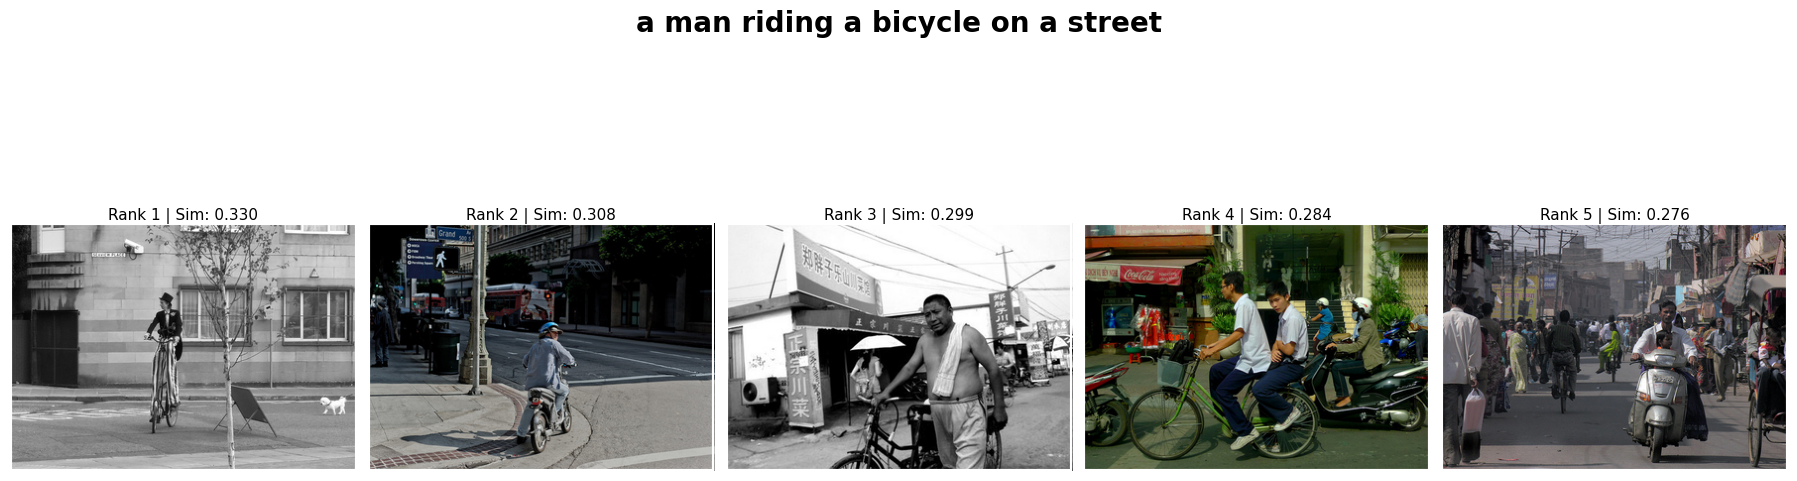

In [32]:
# Cell 12 – Ultra-tight layout with uniform image size + custom title

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import matplotlib.patches as patches

def show_search_results_custom_title(
    query_text, index, image_paths, topk=5, figsize=(18, 6), custom_title=None,
    target_size=(350, 250)   # ← uniform image size (W, H)
):
    results = search_in_index(query_text, index, image_paths, topk=topk)

    fig = plt.figure(figsize=figsize)

    # Use custom title if provided
    title_text = custom_title if custom_title else query_text

    fig.suptitle(
        title_text,
        fontsize=20,
        fontweight="bold",
        y=1.03   # reduced gap
    )

    cols = topk
    for i, (path, sim) in enumerate(results, start=1):

        # Load + center crop + resize for uniform size
        img = Image.open(path).convert("RGB")

        # Center-crop to maintain aesthetic shape
        img = ImageOps.fit(img, target_size, Image.Resampling.LANCZOS)

        ax = fig.add_subplot(1, cols, i)
        ax.imshow(img)
        ax.axis("off")

        # Border
        rect = patches.Rectangle(
            (0, 0), 1, 1,
            linewidth=3,
            edgecolor="white",
            facecolor="none",
            transform=ax.transAxes
        )
        ax.add_patch(rect)

        # Tight title
        ax.set_title(f"Rank {i} | Sim: {sim:.3f}", fontsize=11, pad=2)

    # Ultra-tight layout
    plt.tight_layout(pad=0.8)
    plt.show()


# ---- DEMO ----
demo_query = "a man riding a bicycle on a street"

show_search_results_custom_title(
    demo_query,
    index_coco,
    gallery_paths,
    topk=5,
    custom_title="a man riding a bicycle on a street"
)


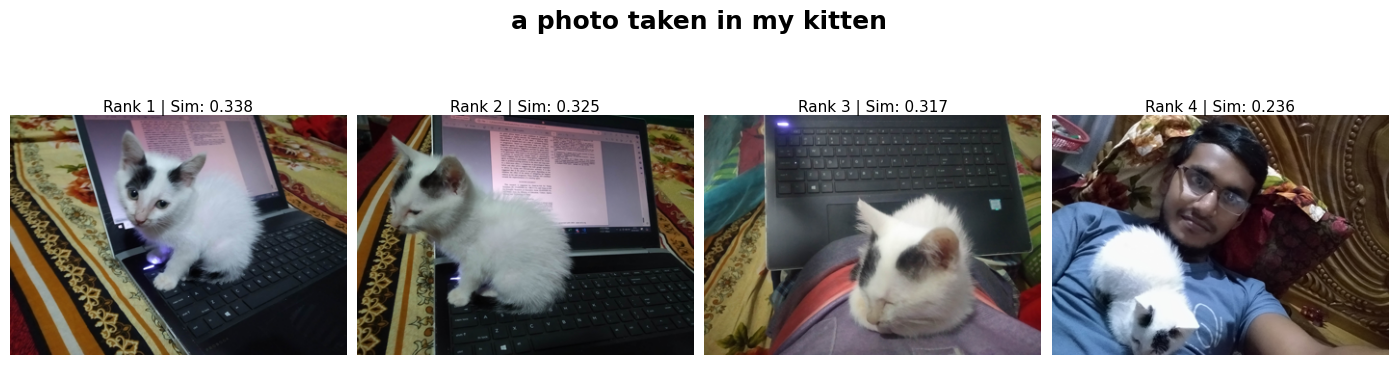

In [33]:
# (Optional) demo on phone images – Tight layout + uniform image size

import matplotlib.pyplot as plt
from PIL import Image

def show_phone_results_tight(query_text, index, image_paths, topk=4, figsize=(14, 4)):
    results = search_in_index(query_text, index, image_paths, topk=topk)

    fig = plt.figure(figsize=figsize)

    # --- Title (placed very close to the images) ---
    fig.suptitle(
        query_text,
        fontsize=18,
        fontweight="bold",
        y=1.02   # ↓ smaller = closer
    )

    # --- Layout settings ---
    cols = topk

    for i, (path, sim) in enumerate(results, start=1):

        # Load & resize image to keep uniform
        img = Image.open(path).convert("RGB")
        img = img.resize((350, 250))  # ← adjust if needed

        ax = fig.add_subplot(1, cols, i)
        ax.imshow(img)
        ax.axis("off")

        # Minimal subtitle (tight padding)
        ax.set_title(
            f"Rank {i} | Sim: {sim:.3f}",
            fontsize=11,
            pad=2  # ← reduces gap between image & title
        )

    # Tight layout (closes all extra spaces)
    plt.tight_layout(pad=0.8)
    plt.show()


# ----- DEMO -----
if index_phone is not None:
    demo_query2 = "a photo taken in my kitten"
    show_phone_results_tight(
        demo_query2,
        index_phone,
        phone_df["image_path"].tolist(),
        topk=4
    )


In [34]:
# Cell 13 – Evaluation metrics: Recall@K

def evaluate_recall(test_df, index, gallery_paths, gallery_mapping=None, topk=(1, 5, 10)):
    """
    test_df must have columns:
      - 'caption': query text
      - 'target_idx': integer index of the correct gallery image (position in gallery_paths)

    gallery_mapping is not used here because we directly store target_idx.
    """
    if len(test_df) == 0:
        print("Empty test set; skipping.")
        return {k: 0.0 for k in topk}

    hits = {k: 0 for k in topk}

    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
        caption = row["caption"]
        target_idx = int(row["target_idx"])

        q_emb = encode_texts([caption])
        max_k = max(topk)
        sims, ids = index.search(q_emb, max_k)
        retrieved = ids[0]

        for k in topk:
            if target_idx in retrieved[:k]:
                hits[k] += 1

    recalls = {k: hits[k] / len(test_df) for k in topk}
    return recalls


In [35]:
# Cell 14 – Prepare TestSet-1 with correct gallery indices

# We already have mapping image_id -> gallery_idx
# just attach target_idx to each row in test1_df

test1_df = test1_df.copy()
test1_df["target_idx"] = test1_df["image_id"].map(imgid_to_gallery_idx)

# Drop any missing indices (should be none if logic above is correct)
test1_df = test1_df.dropna(subset=["target_idx"]).reset_index(drop=True)
test1_df["target_idx"] = test1_df["target_idx"].astype(int)

print("TestSet-1 size:", len(test1_df))
test1_df.head()


TestSet-1 size: 500


,image_id,file_name,image_path,caption,gallery_idx,target_idx
0,113867,000000113867.jpg,/content/coco/val2017/000000113867.jpg,A picture of an open air zone that looks incre...,3711,3711
1,393093,000000393093.jpg,/content/coco/val2017/000000393093.jpg,a green orange and silver train and some cars,1203,1203
2,61171,000000061171.jpg,/content/coco/val2017/000000061171.jpg,Several cows and a horse are eating hay.,1943,1943
3,119088,000000119088.jpg,/content/coco/val2017/000000119088.jpg,The shirtless man plays frisbee in the water.,1969,1969
4,418696,000000418696.jpg,/content/coco/val2017/000000418696.jpg,a traffic light hanging from a wire above a st...,665,665


In [36]:
# Cell 15 – Prepare TestSet-2 with target indices

if len(phone_df) > 0:
    phone_test_df = phone_df.copy()
    phone_test_df["target_idx"] = phone_test_df.index.astype(int)
    print("TestSet-2 size:", len(phone_test_df))
    phone_test_df.head()
else:
    phone_test_df = pd.DataFrame()
    print("No phone test set available yet.")


TestSet-2 size: 16


In [37]:
# Cell 16 – Evaluate search engine on TestSet-1 (COCO)

gallery_paths_coco = gallery_df["image_path"].tolist()
recall_coco = evaluate_recall(
    test1_df[["caption", "target_idx"]],
    index_coco,
    gallery_paths_coco,
    topk=TOPK_EVAL,
)

print("=== TestSet-1 (COCO) Recall@K ===")
for k in TOPK_EVAL:
    print(f"Recall@{k}: {recall_coco[k]:.3f}")


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 123.91it/s]

=== TestSet-1 (COCO) Recall@K ===
Recall@1: 0.392
Recall@5: 0.666
Recall@10: 0.754


In [38]:
# Cell 17 – Evaluate search engine on TestSet-2 (Phone images)

if len(phone_test_df) > 0 and index_phone is not None:
    gallery_paths_phone = phone_df["image_path"].tolist()
    recall_phone = evaluate_recall(
        phone_test_df[["caption", "target_idx"]],
        index_phone,
        gallery_paths_phone,
        topk=TOPK_EVAL,
    )

    print("=== TestSet-2 (Phone) Recall@K ===")
    for k in TOPK_EVAL:
        print(f"Recall@{k}: {recall_phone[k]:.3f}")
else:
    recall_phone = {k: 0.0 for k in TOPK_EVAL}
    print("TestSet-2 not available; no evaluation done.")


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 128.18it/s]

=== TestSet-2 (Phone) Recall@K ===
Recall@1: 0.375
Recall@5: 0.750
Recall@10: 0.812


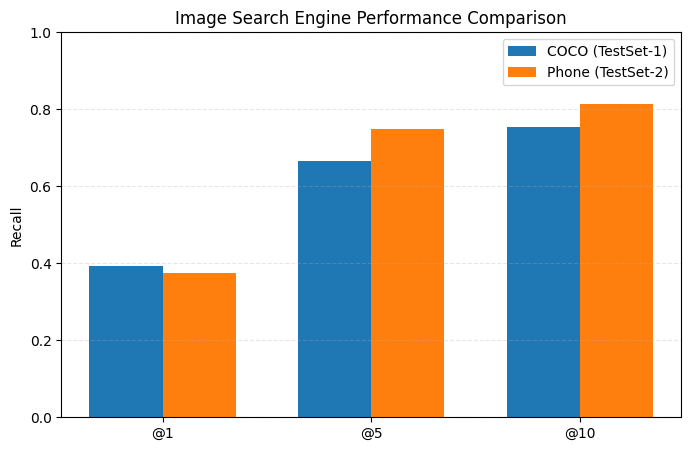

In [39]:
# Cell 18 – Compare Recall@K between TestSet-1 and TestSet-2

labels = [f"@{k}" for k in TOPK_EVAL]
coco_vals = [recall_coco[k] for k in TOPK_EVAL]
phone_vals = [recall_phone[k] for k in TOPK_EVAL]

x = np.arange(len(TOPK_EVAL))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, coco_vals, width, label="COCO (TestSet-1)")
plt.bar(x + width/2, phone_vals, width, label="Phone (TestSet-2)")

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("Recall")
plt.title("Image Search Engine Performance Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


In [40]:
# Cell 19 – Print a textual comparison summary

print("=== Summary ===")
for k in TOPK_EVAL:
    print(
        f"Recall@{k}:  COCO = {recall_coco[k]:.3f}  |  Phone = {recall_phone[k]:.3f}"
    )

print("\nObservation:")
print("- Typically, performance on COCO (in-domain) will be higher.")
print("- Phone images + your own captions are more 'out-of-distribution',")
print("  so Recall@K may drop, which is an important point to discuss.")


=== Summary ===
Recall@1:  COCO = 0.392  |  Phone = 0.375
Recall@5:  COCO = 0.666  |  Phone = 0.750
Recall@10:  COCO = 0.754  |  Phone = 0.812

Observation:
- Typically, performance on COCO (in-domain) will be higher.
- Phone images + your own captions are more 'out-of-distribution',
  so Recall@K may drop, which is an important point to discuss.
